In [1]:
import cv2
import numpy as np
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
import math
import os

### 題目:將影像的瑕疵特徵跟背景分離，留下越多越好

In [2]:
from numpy.lib.stride_tricks import as_strided
#gamma光線校正，輸入灰階影像
def gamma_img(img):
    #計算平均值
    mean=np.mean(img)
    #gamma計算公式
    gamma_calculate=math.log10(0.5)/math.log10(mean/255)
    #gamma變換
    gamma_table=[np.power(x/255.0, gamma_calculate)*255.0 for x in range(256)]
    gamma_table=np.round(np.array(gamma_table)).astype(np.uint8)
    result=cv2.LUT(img,gamma_table)
    #return是numpy.ndarray
    return result
#設定padding
def padding_vector(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value
#padding
def padding(image, kernel_size, padding_vaule):
    image_same_shape = tuple(np.subtract(image.shape, kernel_size.shape) + 1)
    if image_same_shape!=image.shape:
        point= np.subtract(image.shape, image_same_shape) // 2
        if len(np.unique(point))!=1:
            print('error')
        else:
             image_padding= np.pad(image, point[0], padding_vector, padder=padding_vaule)
    else:
        #複製原始圖
        image_padding = np.copy(imag)
    return image_padding
#convoluion
def convolution(image, kernel_size):
    k = kernel_size / (kernel_size.shape[0] * kernel_size.shape[1])
    #影像,kernel_size,padding範圍
    image_pad = padding(image, kernel_size,0)
    view_shape = tuple(np.subtract(image_pad.shape, k.shape) + 1) + k.shape
    strides = image_pad.strides + image_pad.strides
    sub_matrices = as_strided(image_pad, view_shape, strides) 
    result = np.einsum('klij,ij->kl', sub_matrices, k)
    return result
def gaussian_kernel(size):
    size = int(size) // 2
    sigma = 0.3 * ((size*2 - 1) * 0.5 - 1) + 0.8
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g  

def adpt_thold(image, kernel_size, channel):
    k = gaussian_kernel(kernel_size)
    img_padding = padding(image, k)
    view_shape = tuple(np.subtract(img_pad.shape, k.shape) + 1) + k.shape
    strides = img_padding.strides + img_padding.strides
    sub_matrices = as_strided(img_pad, view_shape, strides) 
    thold = np.einsum('klij,ij->kl', sub_matrices, k) / np.sum(k) - channel
    img_adpt_thold = np.less(image, thold)
    return img_adpt_thold

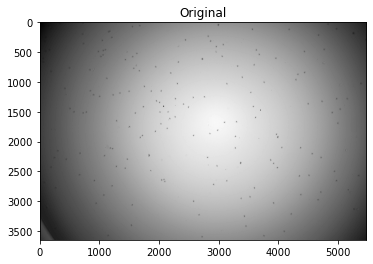

In [28]:
image_path='./test_image/W_A1_0_3.jpg'
filename=(image_path.split('/'))[-1]
#轉灰階
im_gray = cv2.imread(image_path,0)
plt.imshow(im_gray,cmap='gray')
plt.title('Original')
plt.show()

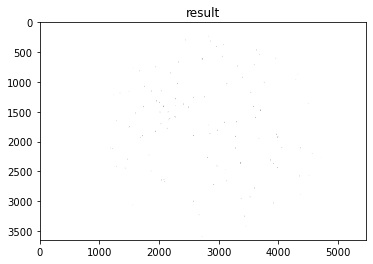

True

In [40]:
#定義kernel
convolution_kernel = np.ones((5, 5))
kernel_dilation=np.ones((5,5),np.uint8)
kernel_dilation2=np.ones((3,3),np.uint8)
kernel_erosion=np.ones((5,5),np.uint8)
kernel_erosion2=np.ones((3,3),np.uint8)

#二維convolution
img_convolution = convolution(im_gray, convolution_kernel)
cv2.imwrite('./img_convolution.jpg',img_convolution)
img_convolution=cv2.imread('./img_convolution.jpg',0)
#gamma光線校正
img_gamma=gamma_img(img_convolution)
cv2.imwrite('./img_gamma.jpg', img_gamma)

#自適應二值化
img_adaptive=cv2.adaptiveThreshold(img_gamma,255,
                                  cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY_INV,5,5)
cv2.imwrite('./img_adaptive.jpg',img_adaptive)
#大侵蝕
img_erosion=cv2.erode(img_adaptive,kernel_erosion,iterations = 2)
#大膨脹
img_dilation=cv2.dilate(img_erosion,kernel_dilation,iterations = 2)
#小膨脹
result=cv2.dilate(img_dilation,kernel_dilation2)
# #小侵蝕
result=cv2.erode(dilation2,kernel_erosion2)
plt.imshow(result,cmap='gray')
plt.title('result')
plt.show()
result_name='./result_image/'+'result_'+filename+'.jpg'
cv2.imwrite(result_name,result)


